Defaulting to user installation because normal site-packages is not writeable


TypeError: Scalar tensor has no `len()`

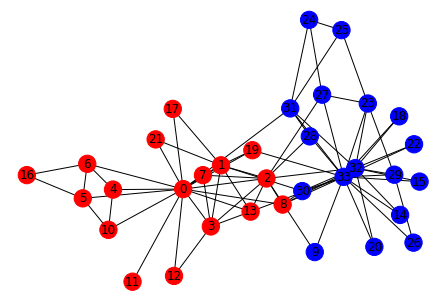

In [3]:
# -*- coding: utf-8 -*-
"""packt-18-dgl-custom-dataset.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1cJ5in4aQ7JfdAGeYuP3bBpiF1XjeEggR

# Custom Dataset

Tensorflow and DGL re-implementation of the PyTorch and DGL based example at [Make Your Own Dataset](https://docs.dgl.ai/tutorials/blitz/6_load_data.html#sphx-glr-tutorials-blitz-6-load-data-py).
"""

# Commented out IPython magic to ensure Python compatibility.
# %env DGLBACKEND=tensorflow

!pip install dgl

"""## Single Graph

"""

# Commented out IPython magic to ensure Python compatibility.
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from dgl.data import DGLDataset

# %matplotlib inline

G = nx.karate_club_graph()

nodes = [n for n in G.nodes]
label_colors = {"Mr. Hi": "red", "Officer": "blue"}
labels = [label_colors[G.nodes[n]["club"]] for n in G.nodes]

nx.draw(G, node_color=labels, with_labels=True)

class KarateClubDataset(DGLDataset):
  def __init__(self):
    super().__init__(name="karate_club")

  def __getitem__(self, i):
    return self.graph

  def __len__(self):
    return 1

  def process(self):
    G = nx.karate_club_graph()
    nodes = [node for node in G.nodes]
    edges = [edge for edge in G.edges]
    node_features = tf.random.uniform(
        (len(nodes), 10), minval=0, maxval=1, dtype=tf.dtypes.float32)
    label2int = {"Mr. Hi": 0, "Officer": 1}
    node_labels = tf.convert_to_tensor(
        [label2int[G.nodes[node]["club"]] for node in nodes])
    edge_features = tf.random.uniform(
        (len(edges), 1), minval=3, maxval=10, dtype=tf.dtypes.int32)
    edges_src = tf.convert_to_tensor([u for u, v in edges])
    edges_dst = tf.convert_to_tensor([v for u, v in edges])

    self.graph = dgl.graph((edges_src, edges_dst), num_nodes=len(nodes))
    self.graph.ndata["feat"] = node_features
    self.graph.ndata["label"] = node_labels
    self.graph.edata["weight"] = edge_features

    # assign masks indicating the split (training, validation, test)
    n_nodes = len(nodes)
    n_train = int(n_nodes * 0.6)
    n_val = int(n_nodes * 0.2)
    train_mask = tf.convert_to_tensor(
      np.hstack([np.ones(n_train), np.zeros(n_nodes - n_train)]), 
      dtype=tf.bool)
    val_mask = tf.convert_to_tensor(
      np.hstack([np.zeros(n_train), np.ones(n_val), np.zeros(n_nodes - n_train - n_val)]),
      dtype=tf.bool)
    test_mask = tf.convert_to_tensor(
      np.hstack([np.zeros(n_train + n_val), np.ones(n_nodes - n_train - n_val)]),
      dtype=tf.bool)
    self.graph.ndata["train_mask"] = train_mask
    self.graph.ndata["val_mask"] = val_mask
    self.graph.ndata["test_mask"] = test_mask


dataset = KarateClubDataset()
g = dataset[0]
print(g)

"""## Multiple Graphs"""

graphs = []
num_graphs = 0
for i in range(10):
  n = np.random.randint(3, 10)
  d = np.random.randint(1, 10)
  if ((n * d) % 2) != 0:
    continue
  if n < d:
    continue
  g = nx.random_regular_graph(d, n)
  graphs.append(g)
  num_graphs += 1
  if num_graphs >= 4:
    break

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
nx.draw(graphs[0])

plt.subplot(2, 2, 2)
nx.draw(graphs[1])

plt.subplot(2, 2, 3)
nx.draw(graphs[2])

plt.subplot(2, 2, 4)
nx.draw(graphs[3])

_ = plt.plot()

from networkx.exception import NetworkXError

class SyntheticDataset(DGLDataset):
  def __init__(self):
    super().__init__(name="synthetic")

  def __getitem__(self, i):
    return self.graphs[i], self.labels[i]

  def __len__(self):
    return len(self.graphs)

  def process(self):
    self.graphs, self.labels = [], []
    num_graphs = 0
    while(True):
      d = np.random.randint(3, 10)
      n = np.random.randint(5, 10)
      if ((n * d) % 2) != 0:
        continue
      if n < d:
        continue
      try:
        g = nx.random_regular_graph(d, n)
      except NetworkXError:
        continue
      g_edges = [edge for edge in g.edges]
      g_src = [u for u, v in g_edges]
      g_dst = [v for u, v in g_edges]
      g_num_nodes = len(g.nodes)
      label = np.random.randint(0, 2)
      # create graph and add to list of graphs and labels
      dgl_graph = dgl.graph((g_src, g_dst), num_nodes=g_num_nodes)
      dgl_graph.ndata["feats"] = tf.random.uniform(
          (g_num_nodes, 10), minval=0, maxval=1, dtype=tf.dtypes.float32)
      self.graphs.append(dgl_graph)
      self.labels.append(label)

      num_graphs += 1
      if num_graphs > 100:
        break

    self.labels = tf.convert_to_tensor(self.labels, dtype=tf.dtypes.int64)



dataset = SyntheticDataset()
graph, label = dataset[0]    
print(graph)
print("label:", label)

